# Naive bayes on Amazon Fine Food reviews

In [ ]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

After preprocessing data we store into final.sqlite and using it 

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [ ]:
download = drive.CreateFile({'id': '1K1rpp1cP61oOjKc9CIx-0v4z2SdyOpyi'})
download.GetContentFile('final.sqlite')


In [ ]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 

## Time based Splitting Test and Train

In [ ]:
final=final.sort_values(by=['Time'],ascending=False)
finalDataPoints=final.head(100000)
x=finalDataPoints["CleanedText"]
y=finalDataPoints["Score"]

#Splitting into test and train
x_1,x_test,y_1,y_test=train_test_split(x, y, test_size=0.2,shuffle=False)

In [ ]:
print(x_1.shape,x_test.shape,y_1.shape,y_test.shape)

In [ ]:
#Splitting into cv and train
x_tr,x_cv,y_tr,y_cv=train_test_split(x_1,y_1,test_size=0.25,shuffle=False)

In [ ]:
print(x_tr.shape,y_tr.shape,x_cv.shape,y_cv.shape,x_test.shape,y_test.shape)

# 1.Bag of Words (BoW)

## 1.1 Unigram

In [0]:
#BOW for unigram
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)

## Multinomial naive Bayes

## 1.1.1 Finding the optimal Alpha Using Gridsearch

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  4.0min finished


Best HyperParameter:  {'alpha': 0.01}
0.8840375


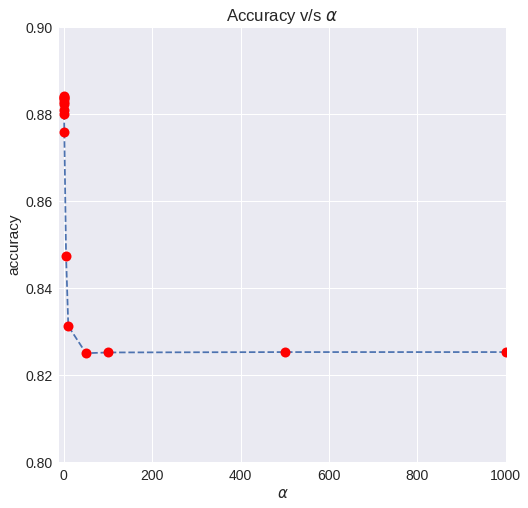

In [140]:
NB = MultinomialNB()
alpha_value = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
gsv = GridSearchCV(NB,alpha_value,cv=5,verbose=1,scoring='f1_micro')
gsv.fit(x_tr_uni,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_alpha=gsv.best_params_['alpha']

x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(-10,1000)
plt.ylim(0.8,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 1.1.2 Finding the F1Score of Test data using optimal alpha

Accuracy on test set: 90.177%
Precision on test set: 0.825
Recall on test set: 0.811
F1-Score on test set: 0.818


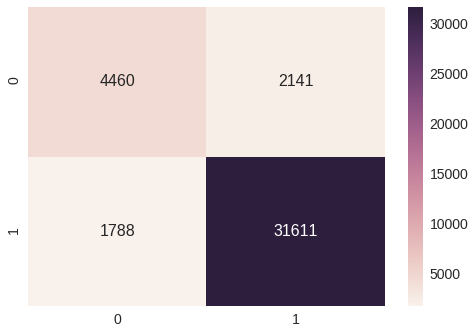

In [13]:
NB = MultinomialNB(optimal_alpha)
NB.fit(x_tr_uni,y_tr)
y_pred = NB.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 1.1.1 Feature Importance

In [163]:
neg_class_prob_sorted = (-NB.feature_log_prob_[0, :]).argsort()
pos_class_prob_sorted = (-NB.feature_log_prob_[1, :]).argsort()
print("important negative features are::\n")
print(np.take(bow.get_feature_names(), neg_class_prob_sorted[:10]))
print("\n\nimportant positve features are::\n")
print(np.take(bow.get_feature_names(), pos_class_prob_sorted[:10]))

important negative features are::

['like' 'tast' 'product' 'one' 'would' 'tri' 'flavor' 'good' 'buy' 'get']


important positve features are::

['like' 'tast' 'love' 'good' 'great' 'flavor' 'use' 'one' 'product' 'tri']


## 1.2 Bi-Grams


In [0]:
bi_gram = CountVectorizer(ngram_range=(1,2))
x_tr_bi = bi_gram.fit_transform(x_tr)
x_test_bi = bi_gram.transform(x_test)

## Multinomial naive Bayes

### 1.2.1 Finding the optimal alpha using gridsearch

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  5.1min finished


Best HyperParameter:  {'alpha': 0.5}
0.897575


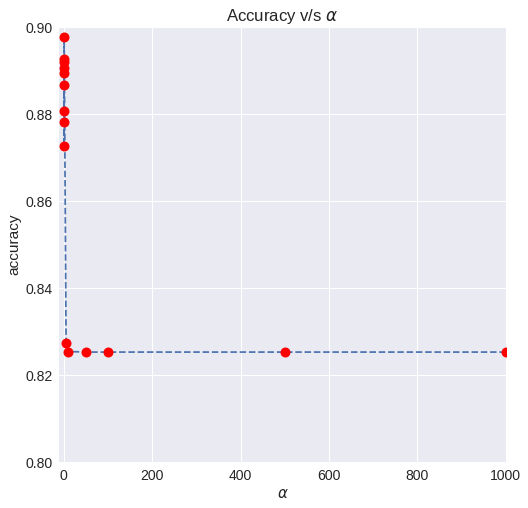

In [143]:
NB = MultinomialNB()
alpha_value = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
gsv = GridSearchCV(NB,alpha_value,cv=5,verbose=1,scoring='f1_micro')
gsv.fit(x_tr_bi,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_alpha=gsv.best_params_['alpha']


x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(-10,1000)
plt.ylim(0.8,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

### 1.2.2 finding the F1-score of Test data using optimal alpha

Accuracy on test set: 91.172%
Precision on test set: 0.893
Recall on test set: 0.766
F1-Score on test set: 0.810


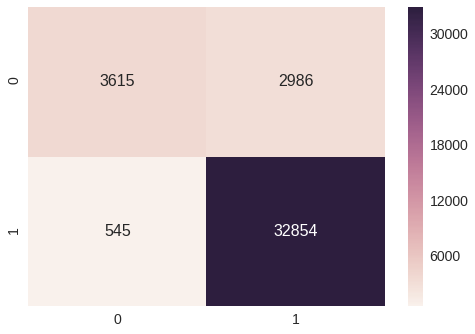

In [16]:
NB = MultinomialNB(optimal_alpha)
NB.fit(x_tr_bi,y_tr)
y_pred = NB.predict(x_test_bi)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## 1.2.3 Top 10 Features

In [191]:
neg_class_prob_sorted = (-NB.feature_log_prob_[0, :]).argsort()
pos_class_prob_sorted = (-NB.feature_log_prob_[1, :]).argsort()
print("important negative features are::\n")
print(np.take(bi_gram.get_feature_names(), neg_class_prob_sorted[:10]))
print("\n\nimportant positve features are::\n")
print(np.take(bi_gram.get_feature_names(), pos_class_prob_sorted[:10]))

important negative features are::

['tast' 'like' 'product' 'one' 'flavor' 'would' 'tri' 'use' 'coffe' 'good']


important positve features are::

['like' 'tast' 'good' 'flavor' 'love' 'use' 'great' 'one' 'product' 'tri']


# 2.TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)

## Multinomial naive Bayes

### 2.1 Finding the optimal alpha using gridsearch

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  5.0min finished


Best HyperParameter:  {'alpha': 0.05}
0.89244375


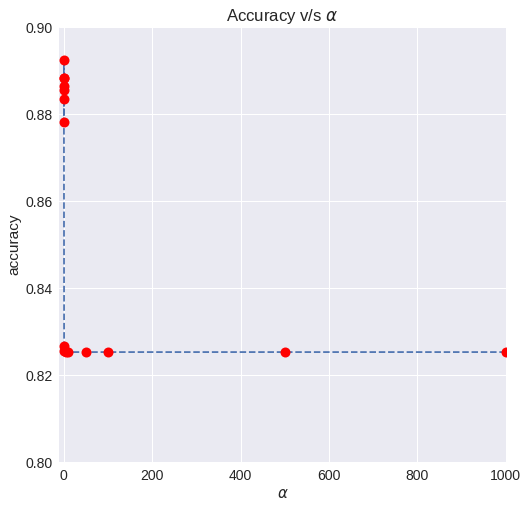

In [147]:
NB = MultinomialNB()
alpha_value = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
gsv = GridSearchCV(NB,alpha_value,cv=5,verbose=1,scoring='f1_micro')
gsv.fit(x_tr_tfidf,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
optimal_alpha=gsv.best_params_['alpha']


x=[]
y=[]
plt.figure(figsize=(8,8))
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(-10,1000)
plt.ylim(0.8,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y,linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.show()

## 2.2 finding the F1-score of Test data using optimal alpha

Accuracy on test set: 89.055%
Precision on test set: 0.902
Recall on test set: 0.682
F1-Score on test set: 0.733


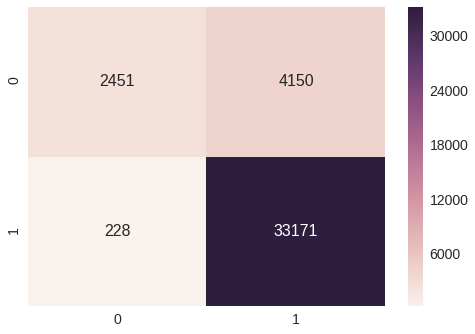

In [19]:
NB = MultinomialNB(optimal_alpha)
NB.fit(x_tr_tfidf,y_tr)
y_pred = NB.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

| Model | hyper parameter   |F1score test|accuracy Test
|------|------|------|------|
|  unigram  |0.01| 0.818|90.17%|
| Bi-gram | 0.5|0.81|91.172%|
|  Tf-IDF | 0.05| 0.733|89.055%|